# Projections GLOB vs HMA of `tas` and `snc`
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [5]:
period_future = slice('2015','2100')
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# HMA for full domain and the following for the above zones
zones = ['GLOB', 'HMA']
zones_df = pd.DataFrame(
    [[slice(None), slice(None)], [lonlim, latlim]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load results

In [3]:
list_models = u.get_model_names_projections()
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

mm_past_ym_zones_tas = xr.open_dataarray('results/projections_GLOB-HMA_tas_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios_tas = xr.open_dataarray('results/projections_GLOB-HMA_tas_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

mm_past_ym_zones_snc = xr.open_dataarray('results/projections_GLOB-HMA_snc_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios_snc = xr.open_dataarray('results/projections_GLOB-HMA_snc_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Compute values

In [52]:
df = pd.DataFrame(index=scenarios, columns=[['tas', 'tas', 'snc', 'snc'], ['GLOB' , 'HMA', 'GLOB' , 'HMA']])
df

tas       snc     
       GLOB  HMA GLOB  HMA
ssp126  NaN  NaN  NaN  NaN
ssp245  NaN  NaN  NaN  NaN
ssp370  NaN  NaN  NaN  NaN
ssp585  NaN  NaN  NaN  NaN

In [53]:
season='Annual'

clim_ref_tas = mm_past_ym_zones_tas.sel(season=season, year=slice('1995','2014')).mean('year')
clim_ref_snc = mm_past_ym_zones_snc.sel(season=season, year=slice('1995','2014')).mean('year')

for i, scenario in enumerate(scenarios):
    HMA_tas = []
    GLOB_tas = []
    HMA_snc = []
    GLOB_snc = []
    
    y_start = 2015
    y_end = 0
    delta = 10
    
    while y_end < 2100-delta:
        y_end = y_start + 20 - 1
        
        for model in list_models:
            # tas
            temp = (
                mm_future_ym_zones_scenarios_tas.sel(
                    season=season, year=slice(str(y_start),str(y_end)), scenario=scenario, model=model
                ).mean('year') - clim_ref_tas.sel(model=model)).squeeze()

            HMA_tas.append(temp.sel(zone='HMA').values)
            GLOB_tas.append(temp.sel(zone='GLOB').values)
            
            # snc
            temp = (
                mm_future_ym_zones_scenarios_snc.sel(
                    season=season, year=slice(str(y_start),str(y_end)), scenario=scenario, model=model
                ).mean('year') - clim_ref_snc.sel(model=model)).squeeze()

            HMA_snc.append(temp.sel(zone='HMA').values)
            GLOB_snc.append(temp.sel(zone='GLOB').values)
            
        y_start += delta
    
    df.loc[scenario, ("tas", "HMA")] = HMA_tas
    df.loc[scenario, ("tas", "GLOB")] = GLOB_tas
    df.loc[scenario, ("snc", "HMA")] = HMA_snc
    df.loc[scenario, ("snc", "GLOB")] = GLOB_snc

In [54]:
df

tas  \
                                                     GLOB   
ssp126  [0.5272077268843987, 0.5923391379198506, 0.742...   
ssp245  [0.5180817188313984, 0.5093499926484686, 0.652...   
ssp370  [0.5643974322306349, 0.45153046440579203, 0.66...   
ssp585  [0.6209957160414312, 0.5521063967711619, 0.724...   

                                                           \
                                                      HMA   
ssp126  [0.601567069034215, 0.9725949049127776, 0.9528...   
ssp245  [0.6191167911641, 0.7254066935138557, 0.986942...   
ssp370  [0.6121827503775965, 0.7203133485993138, 1.085...   
ssp585  [0.6859582665150226, 0.9733903470306515, 1.049...   

                                                      snc  \
                                                     GLOB   
ssp126  [-0.5879862615461526, -0.6948328808715019, -0....   
ssp245  [-0.6248772468257648, -0.6123522523878506, -0....   
ssp370  [-0.626394038282811, -0.4575119099227365, -0.7...   
ssp585  [-0.882249730384487, -0.5664634918607128, -0.8...   

                                                           
                                                      HMA  
ssp126  [-1.6582326112585015, -2.642604418666174, -2.5...  
ssp245  [-2.015676868710731, -0.93344159122951, -3.144...  
ssp370  [-2.142472625091713, -1.059792773380849, -3.44...  
ssp585  [-2.326739458066701, -1.9400971157129732, -3.2...

## Plot

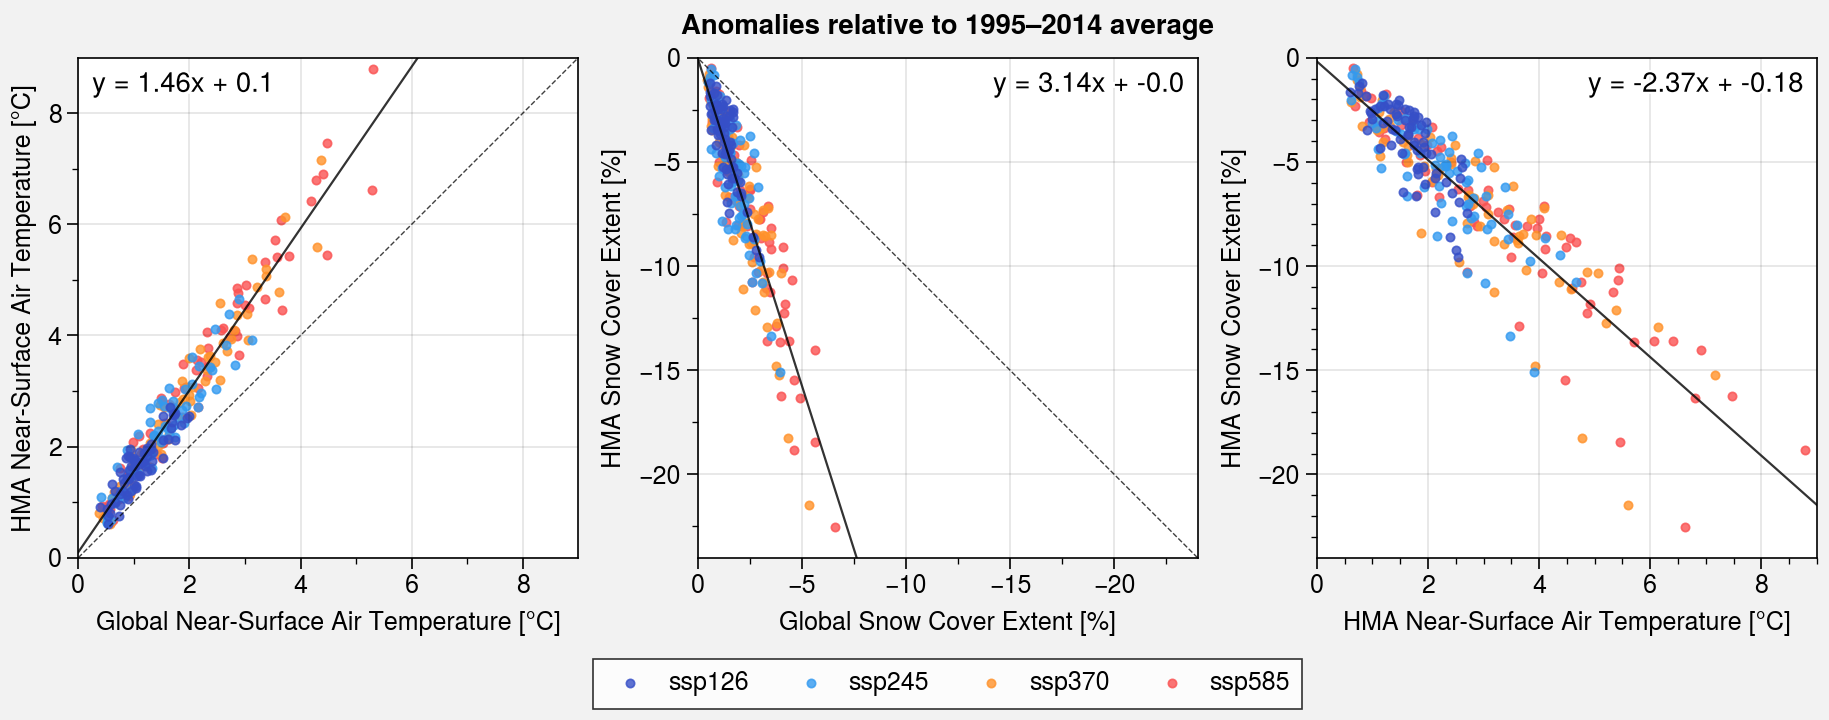

In [126]:
colors = ['indigo9', 'blue5', 'orange5', 'red6']
marker = '.'
alpha = 0.8

# To store results for regression
HMA_tas_all = []
GLOB_tas_all = []
HMA_snc_all = []
GLOB_snc_all = []


# Figure
fig, axs = plot.subplots(ncols=3, nrows=1, share=0)

for i, scenario in enumerate(scenarios):
    axs[0].scatter(df.loc[scenario, ("tas", "GLOB")], df.loc[scenario, ("tas", "HMA")], color=colors[i], label=scenario, zorder=-i, marker=marker, alpha=alpha)
    axs[1].scatter(df.loc[scenario, ("snc", "GLOB")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    axs[2].scatter(df.loc[scenario, ("tas", "HMA")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    
    HMA_tas_all.append(df.loc[scenario, ("tas", "HMA")])
    GLOB_tas_all.append(df.loc[scenario, ("tas", "GLOB")])
    HMA_snc_all.append(df.loc[scenario, ("snc", "HMA")])
    GLOB_snc_all.append(df.loc[scenario, ("snc", "GLOB")])

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
HMA_tas_all = [item for sublist in HMA_tas_all for item in sublist]
GLOB_tas_all = [item for sublist in GLOB_tas_all for item in sublist]
HMA_snc_all = [item for sublist in HMA_snc_all for item in sublist]
GLOB_snc_all = [item for sublist in GLOB_snc_all for item in sublist]
    

lim = (0,9)
axs[0].format(
    xlim=lim, ylim=lim,
    xlabel='Global Near-Surface Air Temperature [°C]',
    ylabel='HMA Near-Surface Air Temperature [°C]',
    xlocator=2, xminorlocator=1.00001,
    ylocator=2, yminorlocator=1.00001,
)

min_snc = -24
axs[1].format(
    xlim=(0,min_snc), ylim=(min_snc,0),
    xlabel='Global Snow Cover Extent [%]',
    ylabel='HMA Snow Cover Extent [%]',
    xlocator=5, xminorlocator=2.5,
    ylocator=5, yminorlocator=2.5,
)

axs[2].format(
    xlim=lim, ylim=(min_snc, 0),
    xlabel='HMA Near-Surface Air Temperature [°C]',
    ylabel='HMA Snow Cover Extent [%]'
)

# https://stackoverflow.com/questions/25497402/adding-y-x-to-a-matplotlib-scatter-plot-if-i-havent-kept-track-of-all-the-data
xy_list = [
    [GLOB_tas_all, HMA_tas_all],
    [GLOB_snc_all, HMA_snc_all],
    [HMA_tas_all, HMA_snc_all]
]
for i, ax in enumerate(axs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=0.5)
    
    # Plot regression
    reg = stats.linregress(xy_list[i][0], xy_list[i][1])
    x = np.array(lims)
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
    
    if i == 0:
        ax.format(ultitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
    else:
        ax.format(urtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
        
    
axs.format(
    suptitle='Anomalies relative to 1995–2014 average'
)

fig.legend(loc='b', frame=True, ncols=4)

filename = 'projections/all_HMA_global'
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')